In [57]:
# 1 Filtering
import findspark
findspark.init()

import pandas as pd

# read T2
df=pd.read_csv("task3_dataset.csv")

# list the columns
list(df)

# print number of rows and columns 
print (df.shape)

# 1.1 Filter rows
# convert string to datetime
df['TimeStemp'] = pd.to_datetime(df['TimeStemp'])

#e ******************
df.dropna()

# filter data by date
dfMondays = df[((df['TimeStemp'] > '2016-05-02 00:00:00') & (df['TimeStemp'] <= '2016-05-02 23:59:59')) | ((df['TimeStemp'] > '2016-05-9 00:00:00') & (df['TimeStemp'] <= '2016-05-9 23:59:59')) | ((df['TimeStemp'] > '2016-05-16 00:00:00') & (df['TimeStemp'] <= '2016-05-16 23:59:59'))]

#agrup *****************
aux=[[]]
aux.remove([])
for index, row in dfMondays.iterrows():
    auxlist=[]
    auxlist.append((row[3].hour*60)+row[3].minute)
    auxlist.append(row[4])
    auxlist.append(row[5])
    auxlist.append(row[6])
    auxlist.append(row[7])
    auxlist.append(row[8])
    auxlist.append(row[9])
    auxlist.append(row[10])
    auxlist.append(row[11])
    auxlist.append(row[12])
    auxlist.append(row[13])
    auxlist.append(row[14])
    auxlist.append(row[15])
    auxlist.append(row[16])
    auxlist.append(row[17])
    aux.append(auxlist)
    
dfMondays = pd.DataFrame(aux, columns =['TimeStemp','GyroscopeStat_x_MEAN','GyroscopeStat_z_MEAN','GyroscopeStat_COV_z_x','GyroscopeStat_COV_z_y','MagneticField_x_MEAN','MagneticField_z_MEAN','MagneticField_COV_z_x','MagneticField_COV_z_y','Pressure_MEAN','LinearAcceleration_COV_z_x','LinearAcceleration_COV_z_y','LinearAcceleration_x_MEAN','LinearAcceleration_z_MEAN','attack'])

# print number of rows and columns
print (dfMondays.shape)

# save data base
dfMondays.to_csv("T3_Mondays.csv", index= False)


(24518, 18)
(4086, 15)


In [58]:
featuredColumns = ['GyroscopeStat_x_MEAN','GyroscopeStat_z_MEAN','GyroscopeStat_COV_z_x','GyroscopeStat_COV_z_y','MagneticField_x_MEAN','MagneticField_z_MEAN','MagneticField_COV_z_x','MagneticField_COV_z_y','Pressure_MEAN','LinearAcceleration_COV_z_x','LinearAcceleration_COV_z_y','LinearAcceleration_x_MEAN','LinearAcceleration_z_MEAN']

In [59]:
# catch training and test values from the dataset
from sklearn.model_selection import train_test_split

# start Naive Bayes
X = dfMondays[featuredColumns]
Y = dfMondays[['attack']]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

In [60]:

# starts Random Forest
from sklearn.ensemble import RandomForestClassifier

# Crear el modelo con 20 arboles
model = RandomForestClassifier(n_estimators=20, 
                               bootstrap = True, verbose=2,
                               max_features = 'sqrt')
# a entrenar!
model.fit(X_train, Y_train.values.ravel())
#Get predictions from the model

predictions = model.predict(X_test)
from sklearn.metrics import confusion_matrix

#Pedimos la matriz de confusión de las predicciones del grupo Test. La diagonal de esta matriz se lee: arriba a la izda True Negatives y abajo a la dcha True Positives. 
confusion_matrix(Y_test,predictions)
from sklearn.metrics import accuracy_score

#Sacamos el índice Accuracy Score, que resume la Matriz de Confusión y la cantidad de aciertos.
accuracy_score(Y_test, predictions)

building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


1.0

In [61]:
from sklearn.ensemble import ExtraTreesClassifier

#Para obtener la importancia de cada variable inicializamos el  ExtraTreesClassifier
model = ExtraTreesClassifier()

/home/mauro/Documents/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/mauro/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[0.19515233 0.12559091 0.07506245 0.02731987 0.07471668 0.10966925
 0.05135473 0.04710298 0.05433645 0.04687011 0.08703397 0.03328047
 0.07250979]


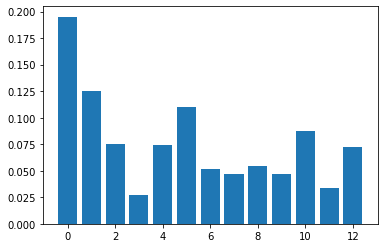

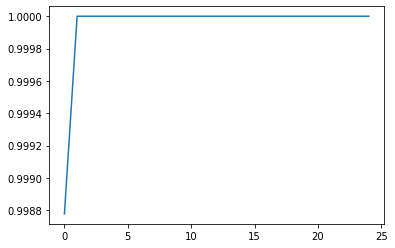

In [62]:

#Ajustamos el modelo

model.fit(X_train,Y_train)
#Pedimos que nos muestre la importancia de cada variable

print(model.feature_importances_)
#Si queremos ver todas las variables en caso de ser muchas, mejor usar el comando «list»

list(model.feature_importances_)
#Para dibujar todos las variables con su importancia

from matplotlib import pyplot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()
import numpy as np
import matplotlib.pylab as plt
from sklearn.metrics import accuracy_score

#Para ver cuánto ha aportado cada nuevo árbol que hemos construido
trees=range(25)
accuracy=np.zeros(25)

for idx in range(len(trees)):
    classifier=RandomForestClassifier(n_estimators=idx + 1)
    classifier=classifier.fit(X_train,Y_train.values.ravel())
    predictions=classifier.predict(X_test)
    accuracy[idx]=accuracy_score(Y_test, predictions)

plt.cla()
plt.plot(trees, accuracy)

In [63]:
featuredColumns = ['TimeStemp','GyroscopeStat_x_MEAN','MagneticField_x_MEAN','LinearAcceleration_x_MEAN','Pressure_MEAN']


In [64]:
#featuredColumns = ['TimeStemp','LinearAcceleration_COV_z_y','LinearAcceleration_z_MEAN']

In [65]:
#featuredColumns = ['TimeStemp','Pressure_MEAN','LinearAcceleration_COV_z_x']

In [66]:
# test size
ts = 0.4

In [67]:
# catch training and test values from the dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# start Naive Bayes
X = dfMondays[featuredColumns]
Y = dfMondays[['attack']]

X_Standard = StandardScaler().fit_transform(X)
X_MinMax = MinMaxScaler().fit_transform(X)

# absolute value for Complement clasification
X_Complement = abs(X)
X_Complement_Standard = abs(X_Standard)
X_Complement_MinMax = abs(X_MinMax)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=ts)
X_train_Standard, X_test_Standard, Y_train_Standard, Y_test_Standard = train_test_split(X_Standard,Y,test_size=ts)
X_train_MinMax, X_test_MinMax, Y_train_MinMax, Y_test_MinMax = train_test_split(X_MinMax,Y,test_size=ts)
X_train_Complement, X_test_Complement, Y_train_Complement, Y_test_Complement = train_test_split(X_Complement,Y,test_size=ts)
X_train_Complement_Standard, X_test_Complement_Standard, Y_train_Complement_Standard, Y_test_Complement_Standard = train_test_split(X_Complement_Standard,Y,test_size=ts)
X_train_Complement_MinMax, X_test_Complement_MinMax, Y_train_Complement_MinMax, Y_test_Complement_MinMax = train_test_split(X_Complement_MinMax,Y,test_size=ts)

In [68]:
# define the algorithm to use
from sklearn.naive_bayes import GaussianNB, ComplementNB

GaussianAlgoritm=GaussianNB()
ComplementAlgoritm=ComplementNB()

In [69]:
#Train the model
GaussianAlgoritm.fit(X_train,Y_train)
GaussianAlgoritm.fit(X_train_Standard,Y_train_Standard)
GaussianAlgoritm.fit(X_train_MinMax,Y_train_MinMax)
ComplementAlgoritm.fit(X_train_Complement,Y_train_Complement)
ComplementAlgoritm.fit(X_train_Complement_Standard,Y_train_Complement_Standard)
ComplementAlgoritm.fit(X_train_Complement_MinMax,Y_train_Complement_MinMax)

/home/mauro/Documents/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mauro/Documents/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mauro/Documents/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mauro/Documents/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [70]:
#Prediction
Y_pred_naive_bayes_Gaussian = GaussianAlgoritm.predict(X_test)
Y_pred_naive_bayes_Gaussian_Standard = GaussianAlgoritm.predict(X_test_Standard)
Y_pred_naive_bayes_Gaussian_MinMax = GaussianAlgoritm.predict(X_test_MinMax)
Y_pred_naive_bayes_Complement = ComplementAlgoritm.predict(X_test_Complement)
Y_pred_naive_bayes_Complement_Standard = ComplementAlgoritm.predict(X_test_Complement_Standard)
Y_pred_naive_bayes_Complement_MinMax = ComplementAlgoritm.predict(X_test_Complement_MinMax)

/home/mauro/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


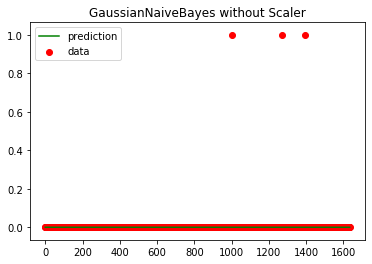

In [71]:
# PLOTTING
import numpy as np
xx =np.stack(i for i in range(len(Y_test)))
plt.scatter(xx,Y_test,c='r',label='data')
plt.plot(xx,Y_pred_naive_bayes_Gaussian,c='g',label='prediction')
plt.axis('tight')
plt.legend()
plt.title("GaussianNaiveBayes without Scaler")
plt.show()

/home/mauro/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


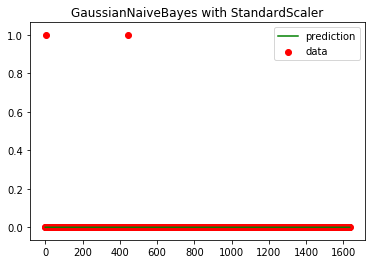

In [72]:
# PLOTTING
import numpy as np
xx =np.stack(i for i in range(len(Y_test_Standard)))
plt.scatter(xx,Y_test_Standard,c='r',label='data')
plt.plot(xx,Y_pred_naive_bayes_Gaussian_Standard,c='g',label='prediction')
plt.axis('tight')
plt.legend()
plt.title("GaussianNaiveBayes with StandardScaler")
plt.show()

/home/mauro/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


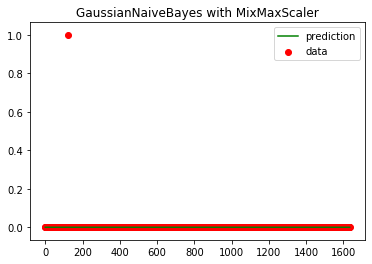

In [73]:
# PLOTTING
import numpy as np
xx =np.stack(i for i in range(len(Y_test_MinMax)))
plt.scatter(xx,Y_test_MinMax,c='r',label='data')
plt.plot(xx,Y_pred_naive_bayes_Gaussian_MinMax,c='g',label='prediction')
plt.axis('tight')
plt.legend()
plt.title("GaussianNaiveBayes with MixMaxScaler")
plt.show()

/home/mauro/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


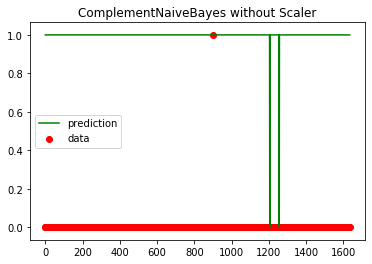

In [74]:
# PLOTTING
import numpy as np
xx =np.stack(i for i in range(len(Y_test_Complement)))
plt.scatter(xx,Y_test_Complement,c='r',label='data')
plt.plot(xx,Y_pred_naive_bayes_Complement,c='g',label='prediction')
plt.axis('tight')
plt.legend()
plt.title("ComplementNaiveBayes without Scaler")
plt.show()

/home/mauro/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


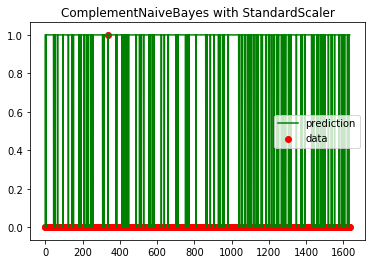

In [75]:
# PLOTTING
import numpy as np
xx =np.stack(i for i in range(len(Y_test_Complement_Standard)))
plt.scatter(xx,Y_test_Complement_Standard,c='r',label='data')
plt.plot(xx,Y_pred_naive_bayes_Complement_Standard,c='g',label='prediction')
plt.axis('tight')
plt.legend()
plt.title("ComplementNaiveBayes with StandardScaler")
plt.show()

/home/mauro/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


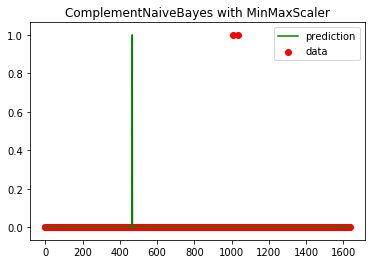

In [76]:
# PLOTTING
import numpy as np
xx =np.stack(i for i in range(len(Y_test_Complement_MinMax)))
plt.scatter(xx,Y_test_Complement_MinMax,c='r',label='data')
plt.plot(xx,Y_pred_naive_bayes_Complement_MinMax,c='g',label='prediction')
plt.axis('tight')
plt.legend()
plt.title("ComplementNaiveBayes with MinMaxScaler")
plt.show()

In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Matriz de confusion:
[[1632    0]
 [   3    0]]
Confusion matrix, without normalization
[[1632    0]
 [   3    0]]


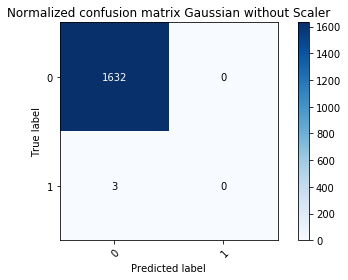

In [78]:
from sklearn.metrics import confusion_matrix

#Confusion matrix
matrix = confusion_matrix(Y_test,Y_pred_naive_bayes_Gaussian)
print("Matriz de confusion:")
print(matrix)
plot_confusion_matrix(Y_test, Y_pred_naive_bayes_Gaussian , classes = unique_labels(Y_test, Y_pred_naive_bayes_Gaussian), normalize=False,
                      title='Normalized confusion matrix Gaussian without Scaler')

Matriz de confusion:
[[1633    0]
 [   2    0]]
Confusion matrix, without normalization
[[1633    0]
 [   2    0]]


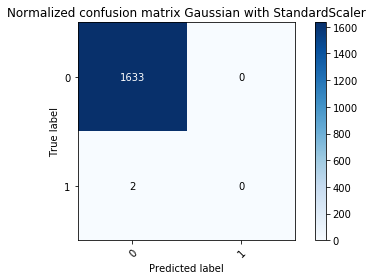

In [79]:
from sklearn.metrics import confusion_matrix

#Confusion matrix
matrix = confusion_matrix(Y_test_Standard,Y_pred_naive_bayes_Gaussian_Standard)
print("Matriz de confusion:")
print(matrix)
plot_confusion_matrix(Y_test_Standard, Y_pred_naive_bayes_Gaussian_Standard , classes = unique_labels(Y_test_Standard, Y_pred_naive_bayes_Gaussian_Standard), normalize=False,
                      title='Normalized confusion matrix Gaussian with StandardScaler')

Matriz de confusion:
[[1634    0]
 [   1    0]]
Confusion matrix, without normalization
[[1634    0]
 [   1    0]]


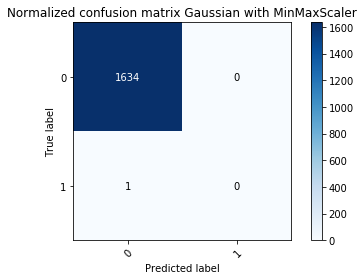

In [80]:
from sklearn.metrics import confusion_matrix

#Confusion matrix
matrix = confusion_matrix(Y_test_MinMax,Y_pred_naive_bayes_Gaussian_MinMax)
print("Matriz de confusion:")
print(matrix)
plot_confusion_matrix(Y_test_MinMax, Y_pred_naive_bayes_Gaussian_MinMax , classes = unique_labels(Y_test_MinMax, Y_pred_naive_bayes_Gaussian_MinMax), normalize=False,
                      title='Normalized confusion matrix Gaussian with MinMaxScaler')

Matriz de confusion:
[[   2 1632]
 [   0    1]]
Confusion matrix, without normalization
[[   2 1632]
 [   0    1]]


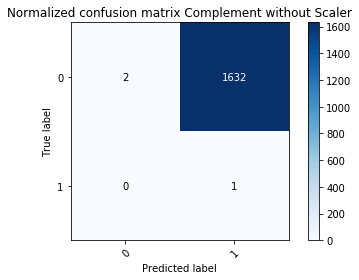

In [81]:
from sklearn.metrics import confusion_matrix

#Confusion matrix
matrix = confusion_matrix(Y_test_Complement,Y_pred_naive_bayes_Complement)
print("Matriz de confusion:")
print(matrix)
plot_confusion_matrix(Y_test_Complement, Y_pred_naive_bayes_Complement , classes = unique_labels(Y_test_Complement, Y_pred_naive_bayes_Complement), normalize=False,
                      title='Normalized confusion matrix Complement without Scaler')

Matriz de confusion:
[[ 124 1510]
 [   1    0]]
Confusion matrix, without normalization
[[ 124 1510]
 [   1    0]]


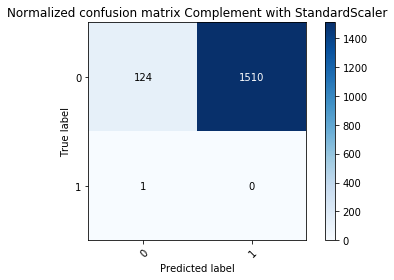

In [82]:
from sklearn.metrics import confusion_matrix

#Confusion matrix
matrix = confusion_matrix(Y_test_Complement_Standard,Y_pred_naive_bayes_Complement_Standard)
print("Matriz de confusion:")
print(matrix)
plot_confusion_matrix(Y_test_Complement_Standard, Y_pred_naive_bayes_Complement_Standard , classes = unique_labels(Y_test_Complement_Standard, Y_pred_naive_bayes_Complement_Standard), normalize=False,
                      title='Normalized confusion matrix Complement with StandardScaler')

Matriz de confusion:
[[1632    1]
 [   2    0]]
Confusion matrix, without normalization
[[1632    1]
 [   2    0]]


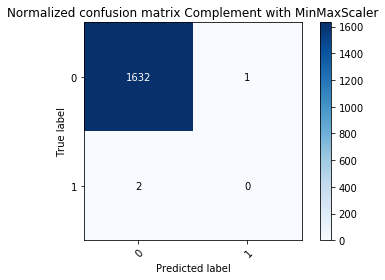

In [83]:
from sklearn.metrics import confusion_matrix

#Confusion matrix
matrix = confusion_matrix(Y_test_Complement_MinMax,Y_pred_naive_bayes_Complement_MinMax)
print("Matriz de confusion:")
print(matrix)
plot_confusion_matrix(Y_test_Complement_MinMax, Y_pred_naive_bayes_Complement_MinMax , classes = unique_labels(Y_test_Complement_MinMax, Y_pred_naive_bayes_Complement_MinMax), normalize=False,
                      title='Normalized confusion matrix Complement with MinMaxScaler')

In [84]:
#Precision of the algorithm
from sklearn.metrics import precision_score 

precision = precision_score(Y_test, Y_pred_naive_bayes, average='weighted', labels= pd.unique(Y_pred_naive_bayes))
print("Precision del modelo:")
print(precision)

NameError: name 'Y_pred_naive_bayes' is not defined

In [ ]:
#HERE START DECISION TREE LEARNER
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext

sqlCtx = SQLContext(sc)

#Convert the dataframe from pandas to sql
dfMondays = sqlCtx.createDataFrame(dfMondays)

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

#Merge selected columns into one
assembler = VectorAssembler(inputCols = featuredColumns, outputCol="features")
assembled = assembler.transform(dfMondays)

#Catch train and test data from chosen columns
(trainingData, testData) = assembled.randomSplit([0.8,0.2], seed=123123) 

trainingData.count(), testData.count()

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

#Start decision tree clasificator
dt = DecisionTreeClassifier(labelCol="attack", featuresCol="features", maxDepth=5, minInstancesPerNode=20, impurity="gini")

In [ ]:
from pyspark.ml import Pipeline

#Normalize data
pipeline = Pipeline(stages=[dt])
model = pipeline.fit(trainingData)

In [ ]:
#Get predictions from the model

predictions = model.transform(testData)

In [ ]:
from pyspark.sql.types import DoubleType

#Convert the attack column from int to double to prevent subsequent failure
predictions = predictions.withColumn("attack", predictions["attack"].cast("double"))

In [ ]:
#Compare first 10 rows (not necesary)
predictions = predictions.select("prediction","attack")
predictions.show(10)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#Show success percentage of the model with the test data
evaluator = MulticlassClassificationEvaluator(labelCol="attack", predictionCol="prediction",metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy:")
print(accuracy)

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

metrics = MulticlassMetrics(predictions.rdd.map(tuple))

In [ ]:
#Confusion matrix from the decision tree
metrics.confusionMatrix().toArray().transpose()